# Pipelines

In [40]:
import json
import matplotlib.pyplot as plt
import datasets
import pandas as pd
from scipy.stats import shapiro, kruskal, spearmanr, wilcoxon
from cliffs_delta import cliffs_delta

In [41]:
def load_pipeline_analysis_data(name):
    """
    Load the analysis data for a pipeline
    
    :param name: the name of the pipeline
    :return: a pandas DataFrame with the analysis data
    """
    file_name = f'pipeline_results/analysis_{name}_result.json'
    with open(file_name, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

def load_pipeline_data(name):
    """
    Load the generated data for a pipeline
    
    :param name: the name of the pipeline
    :return: a pandas DataFrame with the generated data
    """
    file_name = f'pipeline_results/{name}_result.json'
    with open(file_name, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

pipelines_metrics = {
    'pipeline1': load_pipeline_analysis_data('pipeline1'),
    'pipeline2': load_pipeline_analysis_data('pipeline2'),
    'pipeline3': load_pipeline_analysis_data('pipeline3')
}

pipelines = {
    'pipeline1': load_pipeline_data('pipeline1'),
    'pipeline2': load_pipeline_data('pipeline2'),
    'pipeline3': load_pipeline_data('pipeline3')
}

## Creates a sample for manual analysis
The sample contains 40 questions from the test set and the generated questions and distractors from pipeline1.

In [42]:
pipeline1 = load_pipeline_data('pipeline1')
pipeline1.dropna(subset=['generated_question', 'generated_distractors', 'generated_distractors'], inplace=True)
pipeline1.drop(columns=['correct_answer', 'support','time'], axis=1, inplace=True)
pipeline1_sample = pipeline1.sample(40, random_state=42)

pipeline2 = load_pipeline_data('pipeline2')
pipeline2.dropna(subset=['generated_question', 'generated_distractors', 'generated_distractors'], inplace=True)
pipeline2.drop(columns=['correct_answer', 'support','time'], axis=1, inplace=True)
pipeline2_sample = pipeline2.sample(40, random_state=42)

test_data = datasets.load_dataset('allenai/sciq', split='test').to_pandas()
test_data_sample = test_data.loc[pipeline1_sample.index.astype('int32')]
test_data_sample.reset_index(drop=True, inplace=True)
pipeline1_sample.reset_index(drop=True, inplace=True)
manual_sample_1 = pd.concat([test_data_sample, pipeline1_sample], axis=1)
manual_sample_1.to_csv('manual_analysis_1.csv', columns=['question', 'generated_question', 'correct_answer', 'distractor1', 'distractor2', 'distractor3', 'generated_distractors', 'support'])
manual_sample_2 = pd.concat([test_data_sample, pipeline2_sample], axis=1)
manual_sample_2.to_csv('manual_analysis_2.csv', columns=['question', 'generated_question', 'correct_answer', 'distractor1', 'distractor2', 'distractor3', 'generated_distractors', 'support'])


# Evaluate manual scoring

In [43]:
manual_pipe1 = pd.read_csv('pipeline1_manual.csv')
manual_pipe2 = pd.read_csv('pipeline2_manual.csv')
for column in manual_pipe1.columns[1:]:
    manual_pipe1[column] = (manual_pipe1[column] - manual_pipe1[column].mean()) / manual_pipe1[column].std() if manual_pipe1[column].std() != 0 else 0
    manual_pipe2[column] = (manual_pipe2[column] - manual_pipe2[column].mean()) / manual_pipe2[column].std() if manual_pipe2[column].std() != 0 else 0
    
for column in manual_pipe1.columns[1:]:
    stat1, p1 = shapiro(manual_pipe1[column])
    stat2, p2 = shapiro(manual_pipe2[column])
    res = wilcoxon(manual_pipe1[column], manual_pipe2[column], zero_method='zsplit')
    print(f'Wilcoxon test for guideline {column}: stat={res.statistic}, p={res.pvalue}')

Wilcoxon test for guideline 2: stat=410.0, p=1.0
Wilcoxon test for guideline 3: stat=410.0, p=1.0
Wilcoxon test for guideline 4: stat=390.0, p=0.7954479165618977
Wilcoxon test for guideline 5: stat=410.0, p=1.0
Wilcoxon test for guideline 6: stat=289.0, p=0.1058129653429205
Wilcoxon test for guideline 7: stat=410.0, p=1.0
Wilcoxon test for guideline 8: stat=327.0, p=0.27069234351074556
Wilcoxon test for guideline 9: stat=325.0, p=0.259140549798758
Wilcoxon test for guideline 10: stat=410.0, p=1.0
Wilcoxon test for guideline 11: stat=285.0, p=0.09449897358172166
Wilcoxon test for guideline 12: stat=410.0, p=1.0
Wilcoxon test for guideline 13: stat=307.0, p=0.17008811905543553
Wilcoxon test for guideline 14: stat=410.0, p=1.0
Wilcoxon test for guideline 15: stat=410.0, p=1.0
Wilcoxon test for guideline 16: stat=410.0, p=1.0
Wilcoxon test for guideline 17: stat=410.0, p=1.0
Wilcoxon test for guideline 18: stat=410.0, p=1.0
Wilcoxon test for guideline 19: stat=410.0, p=1.0


C:\Users\kaitl\anaconda3\envs\nlpp\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\kaitl\AppData\Local\Temp\ipykernel_39732\1258902167.py:8: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  stat1, p1 = shapiro(manual_pipe1[column])
C:\Users\kaitl\AppData\Local\Temp\ipykernel_39732\1258902167.py:9: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  stat2, p2 = shapiro(manual_pipe2[column])


# Statistical analysis of metrics for QG

In [44]:
pipeline_q_metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'bleurt', 'bertscore']
pipeline_a_metrics = ['bleu_ans', 'rouge1_ans', 'rouge2_ans', 'rougeL_ans', 'bertscore_ans']
print('Shapiro-Wilk test for normality')
for pipeline, df in pipelines_metrics.items():
    for metric in pipeline_q_metrics:
        stat, p = shapiro(df[metric].dropna())
        print(f'{pipeline} {metric} p={p}')
print('Kruskal-Wallis H-test for equal medians')
for metric in pipeline_q_metrics:
    stat, p = kruskal(
        pipelines_metrics['pipeline1'][metric].dropna(),
        pipelines_metrics['pipeline2'][metric].dropna(),
        pipelines_metrics['pipeline3'][metric].dropna(),
    )
    print(f'{metric}: stat={stat}, p={p}')
    
print('Cliff\'s delta for effect size')
for metric in pipeline_q_metrics:
    for pipeline1, pipeline2 in [('pipeline1', 'pipeline2'), ('pipeline1', 'pipeline3'), ('pipeline2', 'pipeline3')]:
        delta = cliffs_delta(pipelines_metrics[pipeline1][metric].dropna(), pipelines_metrics[pipeline2][metric].dropna())
        print(f'{pipeline1} vs {pipeline2} {metric}: {delta}')

Shapiro-Wilk test for normality
pipeline1 bleu p=3.2847378176679806e-29
pipeline1 rouge1 p=7.26513423228254e-19
pipeline1 rouge2 p=2.2768505291170817e-22
pipeline1 rougeL p=1.0334681449284303e-19
pipeline1 bleurt p=1.2010153772797356e-12
pipeline1 bertscore p=3.0883695183016395e-15
pipeline2 bleu p=3.2847378176679806e-29
pipeline2 rouge1 p=7.26513423228254e-19
pipeline2 rouge2 p=2.2768505291170817e-22
pipeline2 rougeL p=1.0334681449284303e-19
pipeline2 bleurt p=1.2010337615688222e-12
pipeline2 bertscore p=3.0882659300946668e-15
pipeline3 bleu p=3.132507480850411e-34
pipeline3 rouge1 p=2.750094980663867e-17
pipeline3 rouge2 p=1.1209317411032445e-27
pipeline3 rougeL p=3.434392416240463e-20
pipeline3 bleurt p=8.748442366554447e-11
pipeline3 bertscore p=9.593870035232002e-11
Kruskal-Wallis H-test for equal medians
bleu: stat=67.52241638326076, p=2.176173813389181e-15
rouge1: stat=125.82617101557298, p=4.7554774262014755e-28
rouge2: stat=114.948794513617, p=1.0944260472012283e-25
rougeL: st

# Analysis of answer metrics

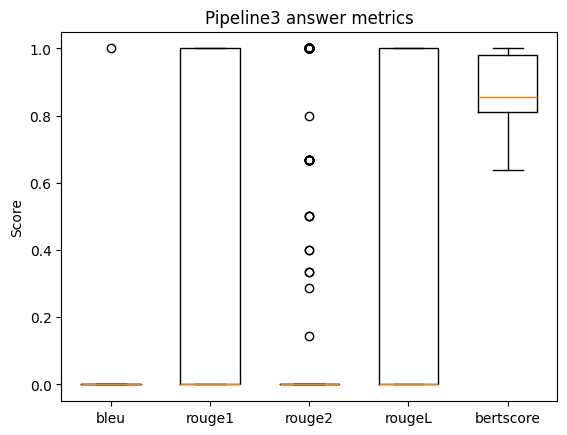

In [45]:
plt.figure()
plt.boxplot(pipelines_metrics['pipeline3']['bleu_ans'].dropna(), positions=[1], widths=0.6)
plt.boxplot(pipelines_metrics['pipeline3']['rouge1_ans'].dropna(), positions=[2], widths=0.6)
plt.boxplot(pipelines_metrics['pipeline3']['rouge2_ans'].dropna(), positions=[3], widths=0.6)
plt.boxplot(pipelines_metrics['pipeline3']['rougeL_ans'].dropna(), positions=[4], widths=0.6)
plt.boxplot(pipelines_metrics['pipeline3']['bertscore_ans'].dropna(), positions=[5], widths=0.6)
plt.xticks([1, 2, 3, 4, 5], ['bleu', 'rouge1', 'rouge2', 'rougeL', 'bertscore'])
plt.title('Pipeline3 answer metrics')
plt.ylabel('Score')
plt.show()

# Analysis of distractors

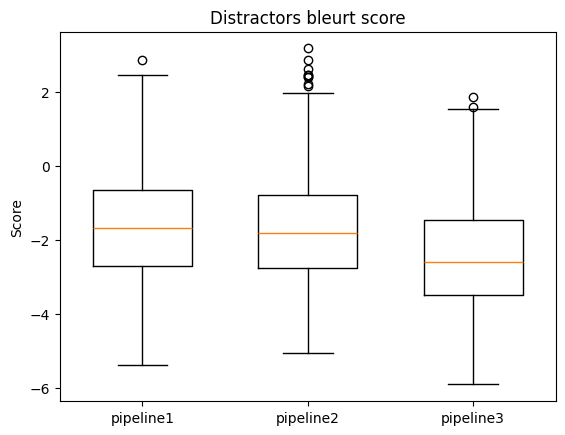

In [46]:
plt.figure()
plt.boxplot(pipelines_metrics['pipeline1']['max_bleurt'].dropna(), positions=[1], widths=0.6)
plt.boxplot(pipelines_metrics['pipeline2']['max_bleurt'].dropna(), positions=[2], widths=0.6)
plt.boxplot(pipelines_metrics['pipeline3']['max_bleurt'].dropna(), positions=[3], widths=0.6)
plt.xticks([1, 2, 3], ['pipeline1', 'pipeline2', 'pipeline3'])
plt.ylabel('Score')
plt.title('Distractors bleurt score')
plt.show()

In [47]:
print('Shapiro-Wilk test for normality')
for pipeline, df in pipelines_metrics.items():
    stat, p = shapiro(df['max_bleurt'].dropna())
    print(f'{pipeline} max_bleurt p={p}')
print('Kruskal-Wallis H-test for equal medians')
stat, p = kruskal(
    pipelines_metrics['pipeline1']['max_bleurt'].dropna(),
    pipelines_metrics['pipeline2']['max_bleurt'].dropna()
)
print(f'Kruskal-Wallis H-test for equal medians: stat={stat}, p={p}')
stat, p = kruskal(
    pipelines_metrics['pipeline1']['max_bleurt'].dropna(),
    pipelines_metrics['pipeline3']['max_bleurt'].dropna()
)
print(f'Kruskal-Wallis H-test for equal medians: stat={stat}, p={p}')
stat, p = kruskal(
    pipelines_metrics['pipeline2']['max_bleurt'].dropna(),
    pipelines_metrics['pipeline3']['max_bleurt'].dropna()
)
print(f'Kruskal-Wallis H-test for equal medians: stat={stat}, p={p}')
print('Cliff\'s delta for effect size')
for pipeline1, pipeline2 in [('pipeline1', 'pipeline2'), ('pipeline1', 'pipeline3'), ('pipeline2', 'pipeline3')]:
    delta = cliffs_delta(pipelines_metrics[pipeline1]['max_bleurt'].dropna(), pipelines_metrics[pipeline2]['max_bleurt'].dropna())
    print(f'{pipeline1} vs {pipeline2}: {delta}')


Shapiro-Wilk test for normality
pipeline1 max_bleurt p=0.00035138697878211035
pipeline2 max_bleurt p=2.80918854674975e-06
pipeline3 max_bleurt p=3.209304847324271e-06
Kruskal-Wallis H-test for equal medians
Kruskal-Wallis H-test for equal medians: stat=2.5659737654217136, p=0.10918530769951335
Kruskal-Wallis H-test for equal medians: stat=139.04505297745672, p=4.305697571307588e-32
Kruskal-Wallis H-test for equal medians: stat=111.65998508936326, p=4.2415795597709305e-26
Cliff's delta for effect size
pipeline1 vs pipeline2: (0.04400247742675211, 'negligible')
pipeline1 vs pipeline3: (0.32391331053827727, 'small')
pipeline2 vs pipeline3: (0.2902684220224811, 'small')


In [48]:
print('Spearmann correlation between time and bleurt')
for name, pipeline in pipelines.items():
    time_non_null = pipeline['time'].dropna()
    bleurt_non_null = pipelines_metrics[name]['max_bleurt'].dropna()
    corr, p = spearmanr(bleurt_non_null, time_non_null)
    print(f'{name} corr={corr}, p={p}')

Spearmann correlation between time and bleurt
pipeline1 corr=-0.017770254085596914, p=0.5977480333686591
pipeline2 corr=0.024918067688372007, p=0.4593400332567552
pipeline3 corr=-0.02594285268595294, p=0.44107764393187665


# Statistical analysis of time

In [49]:
print('Shapiro-Wilk test for normality')
for pipeline, df in pipelines.items():
    stat, p = shapiro(df['time'].dropna())
    print(f'{pipeline} time p={p}')
print('Kruskal-Wallis H-test for equal medians')
stat, p = kruskal(
    pipelines['pipeline1']['time'].dropna(),
    pipelines['pipeline2']['time'].dropna(),
    pipelines['pipeline3']['time'].dropna(),
)
print(f'Kruskal-Wallis H-test for equal medians: stat={stat}, p={p}')
print('Cliff\'s delta for effect size')
for pipeline1, pipeline2 in [('pipeline1', 'pipeline2'), ('pipeline1', 'pipeline3'), ('pipeline2', 'pipeline3')]:
    delta = cliffs_delta(pipelines[pipeline1]['time'].dropna(), pipelines[pipeline2]['time'].dropna())
    print(f'{pipeline1} vs {pipeline2}: {delta}')
    
print('Medians')
print('pipeline1 median: ', pipelines['pipeline1']['time'].median())
print('pipeline2 median: ', pipelines['pipeline2']['time'].median())
print('pipeline3 median: ', pipelines['pipeline3']['time'].median())

print('Means')
print('pipeline1 mean: ', pipelines['pipeline1']['time'].mean())
print('pipeline2 mean: ', pipelines['pipeline2']['time'].mean())
print('pipeline3 mean: ', pipelines['pipeline3']['time'].mean())

Shapiro-Wilk test for normality
pipeline1 time p=1.1565066515063135e-28
pipeline2 time p=7.8617829741935e-55
pipeline3 time p=6.650583923627202e-51
Kruskal-Wallis H-test for equal medians
Kruskal-Wallis H-test for equal medians: stat=130.1471728963079, p=5.48151349843466e-29
Cliff's delta for effect size
pipeline1 vs pipeline2: (0.18428420794005038, 'small')
pipeline1 vs pipeline3: (-0.1596686185786532, 'small')
pipeline2 vs pipeline3: (-0.2975624987203374, 'small')
Medians
pipeline1 median:  5.5843046904
pipeline2 median:  5.1857446432500005
pipeline3 median:  6.66915905475
Means
pipeline1 mean:  7.549248108229072
pipeline2 mean:  10.203678367093666
pipeline3 mean:  9.103634702133483


Spearman correlation between time and support length
pipeline1 corr=0.25507367329869307, p=1.3512148055665394e-14
pipeline2 corr=0.2451492299882807, p=1.4509982359708319e-13
pipeline3 corr=0.2712319737634864, p=2.263532585478515e-16
length 884


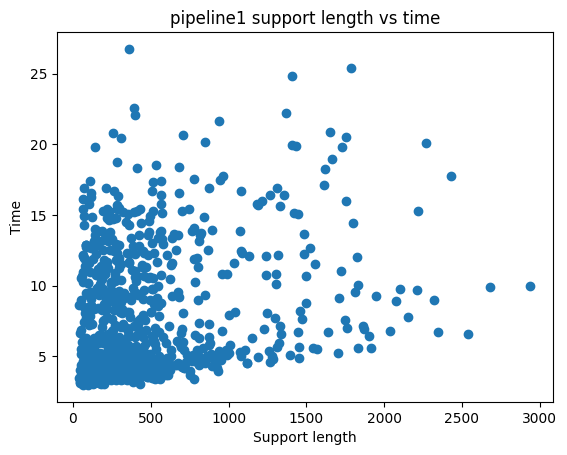

length 884


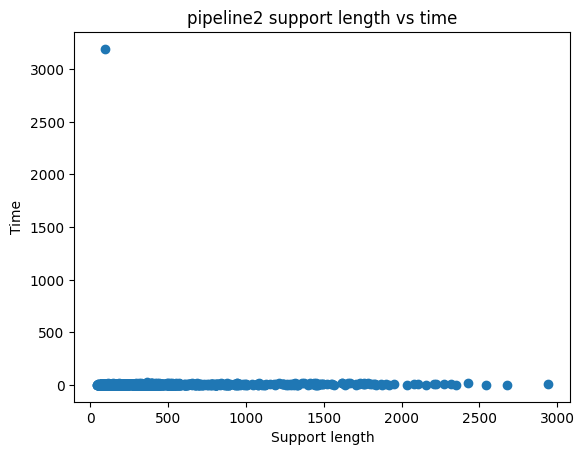

length 884


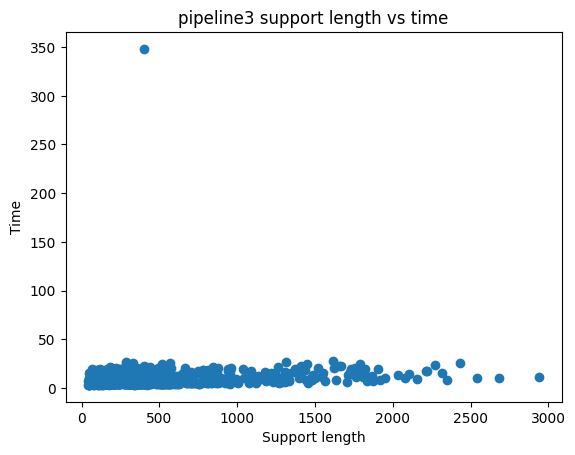

In [50]:
test_data = datasets.load_dataset('allenai/sciq', split='test').to_pandas()
test_data['support_length'] = test_data['support'].apply(lambda x: len(x))
print('Spearman correlation between time and support length')
for name, pipeline in pipelines.items():
    time_non_null = pipeline['time'].dropna()
    test_data_filtered = test_data.loc[time_non_null.index.astype('int32')]

    corr, p = spearmanr(test_data_filtered['support_length'], time_non_null)
    print(f'{name} corr={corr}, p={p}')
    
def plot_correlation(data_length, data_time, title, path):
    plt.figure()
    plt.scatter(data_length['support_length'], data_time)
    plt.xlabel('Support length')
    plt.ylabel('Time')
    plt.title(title)
    plt.show()
    
for name, pipeline in pipelines.items():
    time_non_null = pipeline['time'].dropna()
    print('length', len(time_non_null))
    test_data_filtered = test_data.loc[time_non_null.index.astype('int32')]
    plot_correlation(test_data_filtered, time_non_null, f'{name} support length vs time', name)
    